In [1]:
! pip install numpy
import numpy as np
np.__version__ #checks proper installation of package

'1.24.2'

In [2]:
import cv2 as cv

data = cv.VideoCapture('monte_carlo_low.mp4') 
#using Monte Carlo low as the higher resolution version lengthens processing times

#defining the columns of the empty matrix:

framecount = int(data.get(cv.CAP_PROP_FRAME_COUNT))
framewidth = int(data.get(cv.CAP_PROP_FRAME_WIDTH))
frameheight = int(data.get(cv.CAP_PROP_FRAME_HEIGHT))

#creating a buffer in order to be able to insert the information from the video into it:

buffer = np.empty((framecount, frameheight, framewidth, 3), np.dtype('uint8')) #8-bit unsigned integer, desired output (due to the RGB values)
#the buffer stores information temporarily

##TURNING RGB TO GREYSCALE

#creating a buffer in order to be able to insert the information from the video into it:

buffer_grey = np.empty((framecount, frameheight, framewidth), np.dtype('uint8'))

fc = 0
ret = True

while (fc < framecount and ret):
    ret, buffer[fc] = data.read()
    buffer_grey[fc] = cv.cvtColor(buffer[fc], cv.COLOR_BGR2GRAY) #converts each frame to greyscale
    fc += 1

data.release()

#print(buffer.shape) #(379 [frames], 540 [width], 960 [height], 3 [RGB])
#print(buffer)

print(buffer_grey.shape)
print(buffer_grey)

(379, 540, 960)
[[[ 17  17  17 ...  62  63  63]
  [ 20  20  20 ...  68  68  68]
  [ 23  23  23 ...  79  79  79]
  ...
  [102 102 102 ... 164 164 154]
  [102 102 102 ... 165 167 165]
  [102 102 102 ... 165 163 161]]

 [[ 19  19  19 ...  63  63  63]
  [ 21  21  21 ...  72  72  72]
  [ 26  26  26 ...  84  84  84]
  ...
  [102 102 102 ... 165 167 159]
  [102 102 102 ... 165 168 166]
  [102 102 102 ... 165 163 160]]

 [[ 19  19  19 ...  63  63  63]
  [ 21  21  22 ...  72  72  72]
  [ 26  26  26 ...  84  84  84]
  ...
  [102 102 102 ... 165 167 159]
  [102 102 102 ... 165 168 166]
  [102 102 102 ... 165 163 160]]

 ...

 [[ 26  26  27 ... 116 115 115]
  [ 27  27  26 ... 116 114 114]
  [ 26  26  26 ... 111 111 111]
  ...
  [103 102 102 ... 163 163 163]
  [103 102 102 ... 161 161 161]
  [103 102 102 ... 161 161 161]]

 [[ 26  26  27 ... 115 116 116]
  [ 27  27  26 ... 115 114 114]
  [ 26  26  26 ... 111 111 111]
  ...
  [103 102 102 ... 163 163 163]
  [103 102 102 ... 161 161 161]
  [103 102 1

In [3]:
#organizing the variables for reshaping:

frames = buffer.shape[0]
height = buffer.shape[1]
width = buffer.shape[2]
RGB = buffer.shape[3]

#X = np.reshape(buffer, (frames, height*width, RGB)) #3-D matrix - this was useful for the RGB and hexadecimal trials
X_grey = np.reshape(buffer_grey, (frames, height*width)) #2-D matrix

print(X_grey.shape)
print(X_grey)
#matrix has now been reshaped, the last column has been removed (RGB)

(379, 518400)
[[ 17  17  17 ... 165 163 161]
 [ 19  19  19 ... 165 163 160]
 [ 19  19  19 ... 165 163 160]
 ...
 [ 26  26  27 ... 161 161 161]
 [ 26  26  27 ... 161 161 161]
 [ 26  26  27 ... 161 161 161]]


In [4]:
#rows were stacked, such that we have a TIME X SPACE matrix (frames x height*width)
#take the transpose (not the Hermitian, as there are no complex values)

XT_grey = np.transpose(X_grey)

print(XT_grey.shape)
print(XT_grey)

(518400, 379)
[[ 17  19  19 ...  26  26  26]
 [ 17  19  19 ...  26  26  26]
 [ 17  19  19 ...  27  27  27]
 ...
 [165 165 165 ... 161 161 161]
 [163 163 163 ... 161 161 161]
 [161 160 160 ... 161 161 161]]


In [5]:
#applying the SVD for the first round - it will run heavy
#to run SVD - XT_grey will be split into U, S, and VT matrices

#U,S,VT = np.linalg.svd(XT_grey, full_matrices=True) #"True" condition returns the full SVD (however, too heavy to run)
U,S,VT = np.linalg.svd(XT_grey, full_matrices=False) #"False" condition returns a reduced SVD, allowing the program to run
#the "False" condition truncates the bottom rows that are only 0

np.save('U.npy', U)
np.save('S.npy', S)
np.save('VT.npy', VT)

#checking to see whether the original matrix may be reconstructed:

XT_grey_remake = (U @ np.diag(S) @ VT)
print(XT_grey_remake.shape)
print(XT_grey_remake)

(518400, 379)
[[ 17.  19.  19. ...  26.  26.  26.]
 [ 17.  19.  19. ...  26.  26.  26.]
 [ 17.  19.  19. ...  27.  27.  27.]
 ...
 [165. 165. 165. ... 161. 161. 161.]
 [163. 163. 163. ... 161. 161. 161.]
 [161. 160. 160. ... 161. 161. 161.]]


In [6]:
U = np.load("U.npy")
S = np.load("S.npy")
VT = np.load("VT.npy")

print(U.shape)
print(S.shape)
print(VT.shape)

print(U)
print(S)
print(VT)

(518400, 379)
(379,)
(379, 379)
[[-2.16501171e-04  1.40580131e-04  2.81539222e-04 ... -2.46956221e-05
   2.71500620e-02 -1.88888057e-02]
 [-2.18060639e-04  1.27747886e-04  2.53659123e-04 ... -6.91210462e-05
  -1.09566005e-04  1.79713631e-04]
 [-2.19780252e-04  1.50183028e-04  1.92903486e-04 ... -5.46548450e-05
  -2.06434318e-04  7.95793847e-05]
 ...
 [-1.70118679e-03 -1.52790836e-04  3.61649855e-04 ...  1.20206376e-06
  -1.17728712e-05 -6.00826205e-06]
 [-1.69581267e-03 -1.50655891e-04  3.61424752e-04 ... -7.20742388e-06
  -1.94014043e-05 -9.19461578e-06]
 [-1.68298279e-03 -1.03720292e-04  3.85767556e-04 ...  1.78690629e-06
   8.84965377e-06  2.71182955e-06]]
[1.87112092e+06 2.10481025e+05 9.74892952e+04 7.20526238e+04
 7.05180782e+04 5.75514408e+04 5.16147265e+04 4.70351722e+04
 4.39141951e+04 4.02796633e+04 3.92433954e+04 3.64453069e+04
 3.46432144e+04 3.33901839e+04 3.06801852e+04 2.98136706e+04
 2.87563654e+04 2.81485034e+04 2.74017746e+04 2.72261058e+04
 2.64031318e+04 2.61759283e

In [7]:
##LOW-RANK DECOMPOSITION
#this allows for the identification of the more salient pieces of information

#Eckart-Young-Mirsky theorem:

#computing the rank of the matrix
rank_XT = np.linalg.matrix_rank(XT_grey)

print("Rank of matrix: ", rank_XT)
#print("S = ", S)

#calculating the p-rank: (to avoid redundancy with S)

p = 0
energy = 0

while energy <= 0.99999:
    energy = energy + (S[p]**2 / np.sum(np.diag(S)**2))
    p += 1

print("Optimal p-rank: ", p)

Rank of matrix:  377
Optimal p-rank:  156


In [8]:
#take the transpose (Hermitian) of U in order to run the low-rank SVD: 

def lowrankSVD(p: 'int', U: 'np.ndarry', A):
    return np.dot(np.transpose(U[:, :p]), A)

XT_greys = lowrankSVD(156, U, XT_grey) #computing the low-rank approximation of U and did the dot product with XT_grey
print(XT_greys.shape)
print(XT_greys)

(156, 379)
[[-9.71717485e+04 -9.71839016e+04 -9.71770452e+04 ... -9.68033451e+04
  -9.68066385e+04 -9.67494555e+04]
 [-8.81508781e+03 -8.84274929e+03 -8.84321506e+03 ...  1.28146132e+04
   1.28200203e+04  1.31240563e+04]
 [-7.38576016e+03 -6.76016720e+03 -6.76109612e+03 ...  5.41758501e+02
   5.43523246e+02  2.45128090e+02]
 ...
 [ 1.90320641e+02 -7.59171307e+01 -7.60603521e+01 ...  9.36315718e+00
   8.17240889e+00 -4.25861347e+00]
 [ 2.76660182e+00 -9.84035026e+00 -1.06800053e+01 ...  1.18782099e+01
   1.27817321e+01 -7.60168096e+00]
 [-5.22719674e+00  6.81406322e+00  6.62854995e+00 ... -7.14494562e+00
  -4.60327484e+00  2.77005844e+01]]


In [9]:
##CREATING THE X AND Y:

X = np.delete(XT_greys, -1, 1) #this refers to the removal of the final column, as condition "-1" moves backwards, targeting the final column, and condition "1" targets columns over rows
Y = np.delete(XT_greys, 0, 1) #this refers to the removal of the first column, as condition "0" targets the first column, and condition "1" targets columns over rows

print(X.shape)
print(X)
print(Y.shape)
print(Y)

(156, 378)
[[-9.71717485e+04 -9.71839016e+04 -9.71770452e+04 ... -9.68042439e+04
  -9.68033451e+04 -9.68066385e+04]
 [-8.81508781e+03 -8.84274929e+03 -8.84321506e+03 ...  1.28139742e+04
   1.28146132e+04  1.28200203e+04]
 [-7.38576016e+03 -6.76016720e+03 -6.76109612e+03 ...  5.39128568e+02
   5.41758501e+02  5.43523246e+02]
 ...
 [ 1.90320641e+02 -7.59171307e+01 -7.60603521e+01 ...  9.99867336e+00
   9.36315718e+00  8.17240889e+00]
 [ 2.76660182e+00 -9.84035026e+00 -1.06800053e+01 ...  1.24019038e+01
   1.18782099e+01  1.27817321e+01]
 [-5.22719674e+00  6.81406322e+00  6.62854995e+00 ... -7.26621589e+00
  -7.14494562e+00 -4.60327484e+00]]
(156, 378)
[[-9.71839016e+04 -9.71770452e+04 -9.71771178e+04 ... -9.68033451e+04
  -9.68066385e+04 -9.67494555e+04]
 [-8.84274929e+03 -8.84321506e+03 -8.84334300e+03 ...  1.28146132e+04
   1.28200203e+04  1.31240563e+04]
 [-6.76016720e+03 -6.76109612e+03 -6.76209598e+03 ...  5.41758501e+02
   5.43523246e+02  2.45128090e+02]
 ...
 [-7.59171307e+01 -7.6

In [10]:
## Y = AX; TAKING THE PSEUDOINVERSE OF X:

PX = np.linalg.pinv(X) #pseudoinverse of X

print(PX)

[[-1.97411513e-08 -2.84881618e-07 -7.84587185e-07 ...  9.75659538e-06
   2.88016129e-07 -9.65822132e-07]
 [ 9.58176615e-08 -1.52434105e-06 -8.26621678e-07 ... -2.89675014e-06
   1.39942861e-06 -8.52625985e-06]
 [-9.07522168e-08  4.75710421e-07 -6.52586655e-07 ... -4.36848957e-06
  -1.62283353e-06  5.08230023e-06]
 ...
 [ 3.73606119e-07 -4.01224842e-06 -3.17777877e-07 ...  3.65881544e-06
   7.11384064e-06 -2.98259339e-05]
 [ 2.09902584e-07 -2.25731891e-06 -1.64711794e-07 ...  2.34149819e-06
   4.47435979e-06 -1.78646812e-05]
 [-6.34656672e-07  6.79652214e-06  6.23724001e-07 ... -4.34828056e-06
  -8.93400217e-06  4.39837433e-05]]


In [11]:
##CALCULATING THE DMD MATRIX:

A = np.dot(Y, PX) #multiply the pseudoinverse of X with Y in order to retrieve the matrix A, the DMD matrix

print(A.shape)
print(A)

(156, 156)
[[ 9.99128817e-01  7.99058234e-03  1.07765566e-03 ... -1.03441670e-03
  -1.65006829e-02  5.54239737e-02]
 [-8.20282724e-04  1.00319482e+00  2.36265480e-02 ... -1.12490119e-03
   1.70035340e-04  1.39751821e-02]
 [-2.26071370e-04 -6.24925994e-03  9.93222637e-01 ... -2.65290578e-03
   1.43764811e-02  7.14294388e-02]
 ...
 [ 3.01190962e-05 -2.30005138e-04  1.79843412e-04 ...  1.60332147e-01
   1.18642049e-01 -1.31182074e-01]
 [-3.41581865e-04  3.65969537e-03  3.88730168e-04 ... -6.84850840e-02
   1.31812726e-01 -8.71221224e-02]
 [ 5.42921046e-03 -5.82029123e-02 -5.11174670e-03 ...  6.03097319e-02
   5.01056582e-02  9.42542503e-02]]


In [12]:
##APPLY DMD TO FIND THE EIGENVALUES AND EIGENVECTORS:

eigenvalues, eigenvectors = np.linalg.eig(A) #much like the SVD function, the output must be sorted

print(eigenvalues.shape)
print(eigenvalues)
print(eigenvectors.shape)
print(eigenvectors) #DMD modes (the eigenvectors are referred to as the DMD modes and are assumed to have unit Euclidean norm, p.15)

#inverse of the eigenvectors in order to take the low-rank decomposition of each frame:

eigenvectors_inverse = np.linalg.inv(eigenvectors)

print(eigenvectors_inverse.shape)
print(eigenvectors_inverse)

(156,)
[2.17665888e+01+0.j         2.71229372e-04+0.j
 8.22124534e-01+0.36624853j 8.22124534e-01-0.36624853j
 8.78563169e-01+0.32642687j 8.78563169e-01-0.32642687j
 7.45191466e-01+0.39282057j 7.45191466e-01-0.39282057j
 1.02162578e+00+0.04476333j 1.02162578e+00-0.04476333j
 9.28238934e-01+0.26120959j 9.28238934e-01-0.26120959j
 7.98144585e-01+0.34572842j 7.98144585e-01-0.34572842j
 8.14908709e-01+0.32967941j 8.14908709e-01-0.32967941j
 8.31116465e-01+0.31690658j 8.31116465e-01-0.31690658j
 8.49180345e-01+0.30535343j 8.49180345e-01-0.30535343j
 6.54868571e-01+0.41867932j 6.54868571e-01-0.41867932j
 1.00030365e+00+0.j         7.74606598e-01+0.3582848j
 7.74606598e-01-0.3582848j  7.10170637e-01+0.38803744j
 7.10170637e-01-0.38803744j 6.89344556e-01+0.38996196j
 6.89344556e-01-0.38996196j 7.35562571e-01+0.37971559j
 7.35562571e-01-0.37971559j 8.69384528e-01+0.28867436j
 8.69384528e-01-0.28867436j 6.69261508e-01+0.39874871j
 6.69261508e-01-0.39874871j 6.43186231e-01+0.40494345j
 6.43186231e

In [13]:
##LOW-RANK OF FIRST FRAME:

frame_1 = XT_greys[:,0] #this considers the first frame, which is the first column

print(frame_1.shape)
print(frame_1)

#matrix of coefficients:

#matrix of eigenvectors x matrix of coefficients = initial condition (frame 1)
#inverse of eigenvector matrix is thus taken to solve matrix of coefficients

C = np.dot(eigenvectors_inverse, frame_1)

print(C.shape)
print(C)

(156,)
[-9.71717485e+04 -8.81508781e+03 -7.38576016e+03  1.42846027e+03
 -4.72573651e+03  3.22338759e+02 -1.02016112e+03  5.17968876e+02
 -3.54009919e+02  5.12673921e+02 -1.34324690e+03  1.76890657e+02
 -1.34188640e+03 -1.30726233e+03  3.46447515e+03 -2.03733386e+02
  1.59815342e+02 -6.93206278e+02  5.02390627e+01 -4.78447921e+02
  4.98973523e+02 -1.12715507e+03  1.68737305e+03 -1.22682695e+03
  2.07442844e+03 -7.97916154e+02  6.28899907e+02  9.67196588e+02
 -1.01274363e+03  1.41458384e+03  2.34897351e+02  4.66103180e+02
 -2.57344160e+02  1.06466811e+03 -1.82458807e+03  1.75936889e+03
 -2.48766274e+02  1.34479888e+03 -1.03356145e+03  9.08538029e+02
 -1.03183213e+03  1.34592475e+03 -3.85176023e+02  2.58848238e+02
 -6.11290573e+02  5.02371172e+02 -1.09610380e+03  2.07357317e+02
 -1.67891132e+02  9.00750357e+02 -1.50114807e+01  1.12497901e+02
  7.43855701e+01 -4.09514810e+02  3.85951861e+02 -1.09566560e+03
 -5.13867307e+01  7.75944798e+02  3.28015327e+02  7.86159720e+01
 -2.51135429e+02 -

In [14]:
##EIGENDECOMPOSITION - PART I:

import math

#M = 156 - optimal p-rank
#N = 379 - total frames

C_new = C.reshape(156,1)
eigenva = eigenvalues.reshape(156,1)
Zn = np.empty([156,379], dtype = np.cdouble)
#Zn.reshape(59124,1)
decomp = np.empty([156,1], dtype = np.cdouble)
#defining number of rows as p-rank and number of columns as frames

decomp.reshape(156,1)

print(decomp.shape)
print(decomp.dtype)
print(eigenva.shape)
print(C_new.shape)
print(eigenvectors.shape)
print(Zn.shape)
print(Zn.dtype)

(156, 1)
complex128
(156, 1)
(156, 1)
(156, 156)
(156, 379)
complex128


In [15]:
##EIGENDECOMPOSITION - PART II:
#using the Zn formula on page 15 of the course notes

#m = 0
#n = 1

for n in range(379):
    for m in range(155): #as the first row is 0
        #print(eigenvectors[:,m]) #to check whether the slicing is 'good'
        decomp = decomp + (((eigenva[m+1])**(n+1))*(C_new[m+1])*eigenvectors[:,[m+1]]) #using [m+1] as it is the only way to get around ValueError: could not broadcast input array from shape (156,156) into shape (156,)
    Zn[:,[n]] = decomp
    decomp = np.empty([156,1]) #to initialize next column of Zn

np.save('Zn.npy', Zn)    

print(Zn.shape)
print(Zn)

(156, 379)
[[-9.71841394e+04+6.48947562e-12j -9.71842698e+04+8.43819459e-12j
  -9.71786115e+04+1.30021254e-11j ... -9.92994478e+04-3.06810437e-08j
  -9.96079075e+04-3.61714593e-08j -9.99286595e+04-4.18253001e-08j]
 [-8.84229399e+03+2.32300290e-12j -8.93451070e+03+8.85319595e-13j
  -9.04590652e+03+3.45160012e-12j ...  1.47308896e+04+2.47768506e-08j
   1.46252805e+04+2.18436453e-08j  1.45099577e+04+1.87221101e-08j]
 [-6.76161875e+03           +nanj -6.68738000e+03-1.24432409e-11j
  -6.60844180e+03-1.46320456e-11j ...  2.07266352e+01+1.15781614e-08j
   3.46720738e+02+1.73548702e-08j  6.84630293e+02+2.33536204e-08j]
 ...
 [-7.60049544e+01+7.64188712e-12j -3.54004297e+01+6.37534470e-12j
  -1.57459619e+01+3.28137517e-12j ... -9.43919696e+02-1.81534769e-08j
  -1.00393459e+03-1.91295065e-08j -1.06454503e+03-2.01032343e-08j]
 [-9.52770287e+00+5.71809267e-12j -7.43722539e+00+1.47704071e-12j
  -3.59562746e+00+2.56517030e-12j ... -7.42319055e+02-1.41725914e-08j
  -7.87336752e+02-1.48968837e-08j -8

In [16]:
#importing necessary package for plotting:

import matplotlib.pyplot as lib
from matplotlib.pyplot import plot
from matplotlib.pyplot import margins

In [17]:
"""

##PLOTTING THE LOG OF THE EIGENVALUES:
#this is used to determine the cutoff for the salient eigenvalues

Eplot = np.log(np.absolute(eigenvalues))
lib.plot(Eplot)
lib.title("Figure 1: Logarithm of the Eigenvalues")
lib.xlabel("Eigenvalues")
lib.ylabel("Weight")

lib.show()

"""

'\n\n##PLOTTING THE LOG OF THE EIGENVALUES:\n#this is used to determine the cutoff for the salient eigenvalues\n\nEplot = np.log(np.absolute(eigenvalues))\nlib.plot(Eplot)\nlib.title("Figure 1: Logarithm of the Eigenvalues")\nlib.xlabel("Eigenvalues")\nlib.ylabel("Weight")\n\nlib.show()\n\n'

In [18]:
"""

#zooming into the eigenvalues:

E_zoomplot = np.log(np.absolute(eigenvalues))
lib.margins(x=-0.25,y=-0.00001)
lib.plot(E_zoomplot)
lib.title("Figure 2: Zoomed in - Logarithm of the Eigenvalues")
lib.xlabel("Eigenvalues")
lib.ylabel("Weight")

lib.show()

"""

'\n\n#zooming into the eigenvalues:\n\nE_zoomplot = np.log(np.absolute(eigenvalues))\nlib.margins(x=-0.25,y=-0.00001)\nlib.plot(E_zoomplot)\nlib.title("Figure 2: Zoomed in - Logarithm of the Eigenvalues")\nlib.xlabel("Eigenvalues")\nlib.ylabel("Weight")\n\nlib.show()\n\n'

In [19]:
##DETERMINING THE CUTOFF: DMD SPECTRA

delta_t = 379/6 #frames/second

omega = np.abs(np.log(eigenva))/delta_t
omega_prime = np.log(eigenva)/delta_t

print(omega.shape)
print(omega)

print(omega_prime.shape)
print(omega_prime)

(156, 1)
[[4.87658497e-02]
 [1.30013916e-01]
 [6.84117448e-03]
 [6.84117448e-03]
 [5.72445809e-03]
 [5.72445809e-03]
 [8.14591267e-03]
 [8.14591267e-03]
 [7.78319067e-04]
 [7.78319067e-04]
 [4.38061913e-03]
 [4.38061913e-03]
 [6.83761770e-03]
 [6.83761770e-03]
 [6.41893520e-03]
 [6.41893520e-03]
 [6.05772967e-03]
 [6.05772967e-03]
 [5.70139510e-03]
 [5.70139510e-03]
 [9.84930864e-03]
 [9.84930864e-03]
 [4.80642390e-06]
 [7.30294434e-03]
 [7.30294434e-03]
 [8.59647072e-03]
 [8.59647072e-03]
 [8.94724979e-03]
 [8.94724979e-03]
 [8.11587153e-03]
 [8.11587153e-03]
 [5.26168083e-03]
 [5.26168083e-03]
 [9.38006569e-03]
 [9.38006569e-03]
 [9.89929772e-03]
 [9.89929772e-03]
 [1.17013621e-02]
 [1.17013621e-02]
 [1.80479331e-03]
 [1.80479331e-03]
 [4.70542203e-03]
 [4.70542203e-03]
 [2.27074681e-04]
 [2.27074681e-04]
 [6.07684888e-04]
 [6.07684888e-04]
 [2.71083702e-02]
 [2.71083702e-02]
 [3.20198518e-02]
 [1.03599092e-03]
 [1.03599092e-03]
 [1.29263719e-03]
 [1.29263719e-03]
 [4.22585130e-03]
 

In [20]:
"""

##PLOTTING THE EIGENVALUES ON THE UNIT CIRCLE (NOT CUTOFF):
#this is for observation purposes, to see the cutoff range

lib.axes().set_aspect('equal') #evens out the axes

t = np.linspace(0,np.pi*2,100)
Unitplot = lib.plot(np.cos(t), np.sin(t), linewidth=1)

lib.scatter(omega.real, omega.imag, marker='o', c = 'green', s = 5)
lib.scatter(omega_prime.real, omega_prime.imag, marker='o', c = 'red', s = 5)

lib.title("Eigenvalues")
lib.xlabel("Real")
lib.ylabel("Imaginary")

lib.show()

"""

'\n\n##PLOTTING THE EIGENVALUES ON THE UNIT CIRCLE (NOT CUTOFF):\n#this is for observation purposes, to see the cutoff range\n\nlib.axes().set_aspect(\'equal\') #evens out the axes\n\nt = np.linspace(0,np.pi*2,100)\nUnitplot = lib.plot(np.cos(t), np.sin(t), linewidth=1)\n\nlib.scatter(omega.real, omega.imag, marker=\'o\', c = \'green\', s = 5)\nlib.scatter(omega_prime.real, omega_prime.imag, marker=\'o\', c = \'red\', s = 5)\n\nlib.title("Eigenvalues")\nlib.xlabel("Real")\nlib.ylabel("Imaginary")\n\nlib.show()\n\n'

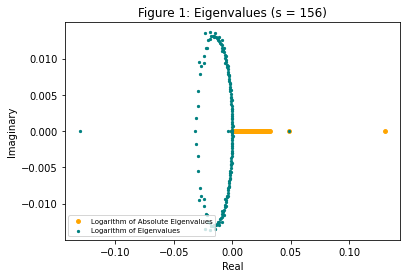

In [21]:
##PLOTTING THE EIGENVALUES (NOT CUTOFF):
#this is for observation purposes, to see the cutoff range

lib.scatter(omega.real, omega.imag, marker='o', c = 'orange', s = 15, label = 'Logarithm of Absolute Eigenvalues')
lib.scatter(omega_prime.real, omega_prime.imag, marker='o', c = 'teal', s = 5, label = 'Logarithm of Eigenvalues')

lib.margins(x=0.05,y=0.05)

lib.title("Figure 1: Eigenvalues (s = 156)")
lib.xlabel("Real")
lib.ylabel("Imaginary")

lib.legend(loc='lower left',prop={'size':7})

lib.savefig("Graph1.png")
lib.show()

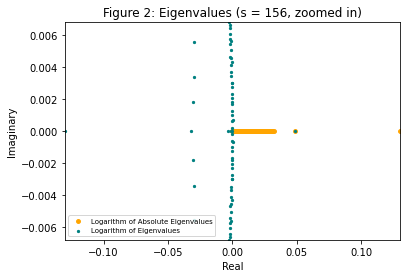

In [22]:
##ZOOMING IN:

lib.scatter(omega.real, omega.imag, marker='o', c = 'orange', s = 15, label = 'Logarithm of Absolute Eigenvalues')
lib.scatter(omega_prime.real, omega_prime.imag, marker='o', c = 'teal', s = 5, label = 'Logarithm of Eigenvalues')

lib.margins(x=0,y=-0.25) #zooming in

lib.title("Figure 2: Eigenvalues (s = 156, zoomed in)")
lib.xlabel("Real")
lib.ylabel("Imaginary")

lib.legend(loc='lower left',prop={'size':7})

lib.savefig("Graph2.png")
lib.show()

In [55]:
##CUTTING-OFF EIGENVALUES:
#reasonable cut off = 0.0001, considering the clustering of the eigenvalues at 0
#separating the eigendecompositional matrix into fast and slow modes

fast = np.zeros([156,1])
slow = np.zeros([156,1])
#empty array designated towards including 'fast' modes

fast_index = 0
slow_index = 0
i = 0

slow_position = 0

for element in omega:
    if element > 0.0001: #leads to a single mode showing up in the low rank
    #if element > 0.001: #leads to 7 modes showing up in the low rank - with no change on the result
        #constructed a larger cutoff point to demonstate what happens when more eigenvalues go into the background
        fast[fast_index] = element
        fast_index = fast_index + 1
        i += 1
    else:
        slow[slow_index] = element
        slow_index = slow_index + 1
        slow_position = i
        i += 1
        
print(fast_index, slow_index)
print(fast)
print(slow)
print(i)
print("The index of the slow mode is: ", slow_position)
print("The slow mode is the 23 element in omega")
#this means that the element with index 22 in the coefficient matrix is the coefficient for the slow eigendecomposition

155 1
[[0.04876585]
 [0.13001392]
 [0.00684117]
 [0.00684117]
 [0.00572446]
 [0.00572446]
 [0.00814591]
 [0.00814591]
 [0.00077832]
 [0.00077832]
 [0.00438062]
 [0.00438062]
 [0.00683762]
 [0.00683762]
 [0.00641894]
 [0.00641894]
 [0.00605773]
 [0.00605773]
 [0.0057014 ]
 [0.0057014 ]
 [0.00984931]
 [0.00984931]
 [0.00730294]
 [0.00730294]
 [0.00859647]
 [0.00859647]
 [0.00894725]
 [0.00894725]
 [0.00811587]
 [0.00811587]
 [0.00526168]
 [0.00526168]
 [0.00938007]
 [0.00938007]
 [0.0098993 ]
 [0.0098993 ]
 [0.01170136]
 [0.01170136]
 [0.00180479]
 [0.00180479]
 [0.00470542]
 [0.00470542]
 [0.00022707]
 [0.00022707]
 [0.00060768]
 [0.00060768]
 [0.02710837]
 [0.02710837]
 [0.03201985]
 [0.00103599]
 [0.00103599]
 [0.00129264]
 [0.00129264]
 [0.00422585]
 [0.00422585]
 [0.00171795]
 [0.00171795]
 [0.03097833]
 [0.03097833]
 [0.02993745]
 [0.02993745]
 [0.03004937]
 [0.03004937]
 [0.02993007]
 [0.02993007]
 [0.01031101]
 [0.01031101]
 [0.00302681]
 [0.00302681]
 [0.0290417 ]
 [0.0290417 ]


In [24]:
##RECONSTRUCTING THE FOREGROUND AND BACKGROUND - PART I:

#FOREGROUND - X_FAST
import copy
fast_C = copy.deepcopy(C_new)
fast_C[22] = 0

print(fast_C)
print(fast_C[22])
print(C_new[22])

Zn_fast = np.empty([156,379], dtype = np.cdouble)
decomp_new = np.empty([156,1], dtype = np.cdouble)
#defining number of rows as p-rank and number of columns as frames
decomp_new.reshape(156,1)

for n in range(379):
    for m in range(155): #as the first row is 0
        decomp_new = decomp_new + (((eigenva[m+1])**(n+1))*(fast_C[m+1])*eigenvectors[:,[m+1]]) #using [m+1] as it is the only way to get around ValueError: could not broadcast input array from shape (156,156) into shape (156,)
    Zn_fast[:,[n]] = decomp_new
    decomp_new = np.empty([156,1]) #to initialize next column of Zn_fast

print(Zn.shape)
print(Zn_fast.shape)
print(Zn_fast)

[[-4.61933196e-01-1.01957124e-10j]
 [ 1.22351739e+04-2.33988185e-11j]
 [ 5.07371668e+00-5.97087726e+00j]
 [ 5.07371668e+00+5.97087726e+00j]
 [ 3.82595641e+00-1.01529663e+01j]
 [ 3.82595641e+00+1.01529663e+01j]
 [ 4.19746136e+01-5.44482881e+00j]
 [ 4.19746136e+01+5.44482881e+00j]
 [-1.35308551e+00-4.25810487e+00j]
 [-1.35308551e+00+4.25810487e+00j]
 [ 1.65105228e+01+5.63614606e+00j]
 [ 1.65105228e+01-5.63614606e+00j]
 [-4.26300024e+03+1.18868255e+03j]
 [-4.26300024e+03-1.18868255e+03j]
 [-8.81391008e+03-3.57288398e+02j]
 [-8.81391008e+03+3.57288398e+02j]
 [-8.04801603e+02-1.20177837e+04j]
 [-8.04801603e+02+1.20177837e+04j]
 [ 5.03834813e+03-6.56165108e+03j]
 [ 5.03834813e+03+6.56165108e+03j]
 [-3.67191119e+01-1.29426530e+01j]
 [-3.67191119e+01+1.29426530e+01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.16088461e+03-3.17240349e+03j]
 [-3.16088461e+03+3.17240349e+03j]
 [-1.11365873e+03-3.68307690e+03j]
 [-1.11365873e+03+3.68307690e+03j]
 [ 1.66032011e+03+6.42689292e+03j]
 [ 1.66032011e+03-6.

In [25]:
##RECONSTRUCTING THE FOREGROUND AND BACKGROUND - PART II:

#BACKGROUND - X_SLOW

Zn_slow = np.subtract(Zn, Zn_fast)

print(Zn_slow.shape)
print(Zn_slow)

(156, 379)
[[-8.93311532e+004+2.13731255e-11j -8.93587407e+004+2.13731255e-11j
  -8.93854126e+004+2.13731255e-11j ... -1.00133677e+005+2.39310793e-11j
  -1.00164082e+005+2.39595010e-11j -1.00194497e+005+2.39595010e-11j]
 [ 7.78604960e+003-3.63797881e-12j -4.44676004e+003+0.00000000e+00j
   7.79077881e+003+0.00000000e+00j ...  8.72759104e+003-2.04636308e-12j
   8.73024119e+003-2.04636308e-12j  8.73289214e+003-2.04636308e-12j]
 [-1.51355471e+002           +nanj -1.56475147e+002+0.00000000e+00j
  -1.45476526e+002+0.00000000e+00j ... -1.69658391e+002+1.13686838e-13j
  -1.69709908e+002+0.00000000e+00j -1.75732318e+002+1.13686838e-13j]
 ...
 [-1.06885917e+002+1.13686838e-13j -4.91675740e+002+5.68434189e-14j
   5.88172210e+001+2.84217094e-14j ... -1.19811280e+002+2.84217094e-14j
  -1.19847661e+002+2.84217094e-14j -2.85652113e+002+2.84217094e-14j]
 [-7.89937837e+001+0.00000000e+00j -4.63775138e+002+0.00000000e+00j
  -2.44809824e+002+2.84217094e-14j ... -8.85462429e+001+2.13162821e-14j
  -2.223

In [26]:
##CONSTRUCTING THE R MATRIX - PART I: MERCI NADA!

absZn_slow = np.abs(Zn_slow)
LabsZn_slow = np.zeros([518400, 379])

for i in range(379):
    for j in range(156):
        LabsZn_slow[j][i] = absZn_slow[j][i]

print(LabsZn_slow.shape)
print(LabsZn_slow)

(518400, 379)
[[ 89331.15317498  89358.7406798   89385.41255495 ... 100133.67652976
  100164.08230779 100194.49731859]
 [  7786.04959878   4446.76004425   7790.77881371 ...   8727.59103917
    8730.2411885    8732.89214256]
 [            nan    156.47514673    145.47652613 ...    169.65839132
     169.70990841    175.7323184 ]
 ...
 [     0.              0.              0.         ...      0.
       0.              0.        ]
 [     0.              0.              0.         ...      0.
       0.              0.        ]
 [     0.              0.              0.         ...      0.
       0.              0.        ]]


In [27]:
##CONSTRUCTING THE R MATRIX - PART II:

sparse = np.subtract(XT_grey,LabsZn_slow)
#must subtract the slow from the transposed video data

print(sparse.shape)
print(sparse)

R = np.zeros([518400,379], dtype = 'float')

for j in range(379):
    for l in range(156):
        if sparse[l][j] < 0.00:
            R[l][j] = sparse[l][j] #double indices due to 2-D array
    
print(R.shape)
print(R)

(518400, 379)
[[ -89314.15317498  -89339.7406798   -89366.41255495 ... -100107.67652976
  -100138.08230779 -100168.49731859]
 [  -7769.04959878   -4427.76004425   -7771.77881371 ...   -8701.59103917
    -8704.2411885    -8706.89214256]
 [             nan    -137.47514673    -126.47652613 ...    -142.65839132
     -142.70990841    -148.7323184 ]
 ...
 [    165.             165.             165.         ...     161.
      161.             161.        ]
 [    163.             163.             163.         ...     161.
      161.             161.        ]
 [    161.             160.             160.         ...     161.
      161.             161.        ]]
(518400, 379)
[[ -89314.15317498  -89339.7406798   -89366.41255495 ... -100107.67652976
  -100138.08230779 -100168.49731859]
 [  -7769.04959878   -4427.76004425   -7771.77881371 ...   -8701.59103917
    -8704.2411885    -8706.89214256]
 [      0.            -137.47514673    -126.47652613 ...    -142.65839132
     -142.70990841    -148.7

In [28]:
##FINALIZING SLOW AND FAST MODES:

lowrank = np.add(R, LabsZn_slow)
final_sparse = np.subtract(sparse, R) #as described in the methodology

print(lowrank.shape)
print(lowrank)
print(final_sparse.shape)
print(final_sparse)

(518400, 379)
[[17. 19. 19. ... 26. 26. 26.]
 [17. 19. 19. ... 26. 26. 26.]
 [nan 19. 19. ... 27. 27. 27.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(518400, 379)
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [ nan   0.   0. ...   0.   0.   0.]
 ...
 [165. 165. 165. ... 161. 161. 161.]
 [163. 163. 163. ... 161. 161. 161.]
 [161. 160. 160. ... 161. 161. 161.]]


In [29]:
##RECONSTRUCTING VIDEO:
#now, lowrank and final_sparse should no longer contain negative values

print(XT_grey.shape)
print(XT_grey)

RECON_VIDEO = np.add(lowrank, final_sparse)

print(RECON_VIDEO.shape)
print(RECON_VIDEO)

(518400, 379)
[[ 17  19  19 ...  26  26  26]
 [ 17  19  19 ...  26  26  26]
 [ 17  19  19 ...  27  27  27]
 ...
 [165 165 165 ... 161 161 161]
 [163 163 163 ... 161 161 161]
 [161 160 160 ... 161 161 161]]
(518400, 379)
[[ 17.  19.  19. ...  26.  26.  26.]
 [ 17.  19.  19. ...  26.  26.  26.]
 [ nan  19.  19. ...  27.  27.  27.]
 ...
 [165. 165. 165. ... 161. 161. 161.]
 [163. 163. 163. ... 161. 161. 161.]
 [161. 160. 160. ... 161. 161. 161.]]


In [30]:
from PIL import Image as im #importing module to view frames as images

##FRAME IMAGES - PART I:
#image 1 - one of the first frames

RECON_IM1 = RECON_VIDEO[:,[2]]
RECON_IM1.shape
RECON_IM1 = RECON_IM1.reshape(540,960)

IM1 = im.fromarray(RECON_IM1)
IM1 = IM1.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

IM1.save("IM1.png")

In [32]:
##FRAME IMAGES - PART II:
#image 2 - one of the last frames

RECON_IM2 = RECON_VIDEO[:,[374]]
RECON_IM2.shape
RECON_IM2 = RECON_IM2.reshape(540,960)

IM2 = im.fromarray(RECON_IM2)
IM2 = IM2.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

IM2.save("IM2.png")

In [33]:
##RECONSTRUCTING FRAME IMAGES - PART I: LOW RANK
#image 3 - one of the first frames

LOW_IM1 = lowrank[:,[2]]
LOW_IM1.shape
LOW_IM1 = LOW_IM1.reshape(540,960)

LIM1 = im.fromarray(LOW_IM1)
LIM1 = LIM1.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

LIM1.save("LIM1.png")

In [34]:
##RECONSTRUCTING FRAME IMAGES - PART II: LOW RANK
#image 4 - one of the first frames

LOW_IM2 = lowrank[:,[374]]
LOW_IM2.shape
LOW_IM2 = LOW_IM2.reshape(540,960)

LIM2 = im.fromarray(LOW_IM2)
LIM2 = LIM2.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

LIM2.save("LIM2.png")

In [35]:
##RECONSTRUCTING FRAME IMAGES - PART I: SPARSE
#image 5 - one of the first frames

S_IM1 = final_sparse[:,[2]]
S_IM1.shape
S_IM1 = S_IM1.reshape(540,960)

SIM1 = im.fromarray(S_IM1)
SIM1 = SIM1.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

SIM1.save("SIM1.png")

In [36]:
##RECONSTRUCTING FRAME IMAGES - PART II: SPARSE
#image 6 - one of the first frames

S_IM2 = final_sparse[:,[374]]
S_IM2.shape
S_IM2 = S_IM2.reshape(540,960)

SIM2 = im.fromarray(S_IM2)
SIM2 = SIM2.convert("L") #solves OSError: cannot write mode F as PNG (must use this for greyscale images)

SIM2.save("SIM2.png")

In [37]:
#THE FRAMES MUST BE RECONSTRUCTED SO WE MAY PROVE FOREGOUND/BACKGROUND VISUALLY - ARRAY TO SNAPSHOT/VIDEO
#FINALIZE GRAPHS AND LABEL EVERYTHING!

In [38]:
"""

##RECONSTRUCTING THE FRAMES:

VIDEO = np.transpose(RECON_VIDEO)

print(VIDEO.shape)

"""

'\n\n##RECONSTRUCTING THE FRAMES:\n\nVIDEO = np.transpose(RECON_VIDEO)\n\nprint(VIDEO.shape)\n\n'

In [39]:
"""

##PRINTING THE FRAMES FROM THE MATRICES: ATTEMPT (FAILED)
#as matrix multiplication is distributive, can multiply by U_new now

print(buffer_grey.shape)
original_video = np.reshape(XT_grey, [height, width, frames])
print(original_video.shape)

final_video = np.reshape(VIDEO, (frames, height, width, 1))
print(final_video.shape)

fourcc = cv.VideoWriter_fourcc(*'MP42') #fourCC is a 4-byte code used to specify the video codec.

FVIDEO = cv.VideoWriter('final_video.mp4', fourcc, float(379/6), (960, 540))
FVIDEO.release()

np.save('final_video.mp4', FVIDEO)

"""

"\n\n##PRINTING THE FRAMES FROM THE MATRICES: ATTEMPT (FAILED)\n#as matrix multiplication is distributive, can multiply by U_new now\n\nprint(buffer_grey.shape)\noriginal_video = np.reshape(XT_grey, [height, width, frames])\nprint(original_video.shape)\n\nfinal_video = np.reshape(VIDEO, (frames, height, width, 1))\nprint(final_video.shape)\n\nfourcc = cv.VideoWriter_fourcc(*'MP42') #fourCC is a 4-byte code used to specify the video codec.\n\nFVIDEO = cv.VideoWriter('final_video.mp4', fourcc, float(379/6), (960, 540))\nFVIDEO.release()\n\nnp.save('final_video.mp4', FVIDEO)\n\n"

In [40]:
"""

##RECONSTRUCTING THE FRAMES: ATTEMPT (FAILED)

U_new = np.resize(U, (518400,156)) #this serves to truncate U to have the significant values
print(U_new.shape)

Zn = np.load("Zn.npy")
print(Zn.shape)

RECON = np.matmul(U_new,Zn)

print(RECON.shape)
print(RECON)

RECON_FAST = np.matmul(U_new,final_sparse)
RECON_SLOW = np.matmul(U_new,lowrank)

print(RECON_FAST.shape)
print(RECON_SLOW.shape)

"""

'\n\n##RECONSTRUCTING THE FRAMES: ATTEMPT (FAILED)\n\nU_new = np.resize(U, (518400,156)) #this serves to truncate U to have the significant values\nprint(U_new.shape)\n\nZn = np.load("Zn.npy")\nprint(Zn.shape)\n\nRECON = np.matmul(U_new,Zn)\n\nprint(RECON.shape)\nprint(RECON)\n\nRECON_FAST = np.matmul(U_new,final_sparse)\nRECON_SLOW = np.matmul(U_new,lowrank)\n\nprint(RECON_FAST.shape)\nprint(RECON_SLOW.shape)\n\n'

In [41]:
"""

#determining the type of data, in order to ensure the information is properly organized:
#this was useful for the RGB and hexadecimal trials
print(type(X.shape[0]))
print(type(X.shape[1]))
print(type(X.shape[2]))

"""

'\n\n#determining the type of data, in order to ensure the information is properly organized:\n#this was useful for the RGB and hexadecimal trials\nprint(type(X.shape[0]))\nprint(type(X.shape[1]))\nprint(type(X.shape[2]))\n\n'

In [42]:
"""

##ATTEMPT : STACKING RGB ROWS (FAILED)
#it has failed as it never stopped running - there are too many data points and 16 Go of RAM is not enough to run the reshaping of each pixel

#turning a 3-D matrix into a 2-D matrix (maintaining RGB):
print(X[0].shape)
print(X[0][0])
print(np.reshape(X[0][0],(3,1)))

#print(np.append(np.reshape(X[0][0],(3,1)),np.reshape(X[0][0],(3,1)),0)) #attempt on a single pixel

X_new = np.empty((frames,X[0].shape[0]*X[0].shape[1]),np.dtype('uint8'))

for frame in X:
    temp_frame = np.empty((1,X[0].shape[0]*X[0].shape[1]),np.dtype('uint8'))
    for pixel in frame:
        np.reshape(pixel,(3,1))
        np.append(temp_frame,pixel)
    
    np.append(X_new,temp_frame,axis=0)
    
    print(temp_frame)

print(X_new.shape)
print(X_new)

"""

"\n\n##ATTEMPT : STACKING RGB ROWS (FAILED)\n#it has failed as it never stopped running - there are too many data points and 16 Go of RAM is not enough to run the reshaping of each pixel\n\n#turning a 3-D matrix into a 2-D matrix (maintaining RGB):\nprint(X[0].shape)\nprint(X[0][0])\nprint(np.reshape(X[0][0],(3,1)))\n\n#print(np.append(np.reshape(X[0][0],(3,1)),np.reshape(X[0][0],(3,1)),0)) #attempt on a single pixel\n\nX_new = np.empty((frames,X[0].shape[0]*X[0].shape[1]),np.dtype('uint8'))\n\nfor frame in X:\n    temp_frame = np.empty((1,X[0].shape[0]*X[0].shape[1]),np.dtype('uint8'))\n    for pixel in frame:\n        np.reshape(pixel,(3,1))\n        np.append(temp_frame,pixel)\n    \n    np.append(X_new,temp_frame,axis=0)\n    \n    print(temp_frame)\n\nprint(X_new.shape)\nprint(X_new)\n\n"

In [43]:
"""

#installing library necessary for hexadecimal: (FAILED - SEE BELOW)
! pip install matplotlib.colors
from matplotlib.colors import rgb2hex

"""

'\n\n#installing library necessary for hexadecimal: (FAILED - SEE BELOW)\n! pip install matplotlib.colors\nfrom matplotlib.colors import rgb2hex\n\n'

In [44]:
"""

##TURNING RGB TO HEX (FAILED)

#turning a 3-D matrix into a 2-D matrix (hex):
print(X.shape)
print(X[0].shape)

X_new = np.empty((frames,X[0].shape[0]*X[0].shape[1]),np.dtype('uint32')) #as hex is the hexademical system, 'uint16' must be used

for frame in X:
    temp_frame = np.empty((1,X[0].sh1ape[0]*X[0].shape[1]),np.dtype('uint32'))
    for pixel in frame:
        rgb2hex(pixel/255) #due to value error: RGBA values should be within 0-1 range
        np.append(temp_frame,pixel)
    
    np.append(X_new,temp_frame,axis=0)
    
    #print(temp_frame)

print(X_new.shape)
#print(X_new)

"""

"\n\n##TURNING RGB TO HEX (FAILED)\n\n#turning a 3-D matrix into a 2-D matrix (hex):\nprint(X.shape)\nprint(X[0].shape)\n\nX_new = np.empty((frames,X[0].shape[0]*X[0].shape[1]),np.dtype('uint32')) #as hex is the hexademical system, 'uint16' must be used\n\nfor frame in X:\n    temp_frame = np.empty((1,X[0].sh1ape[0]*X[0].shape[1]),np.dtype('uint32'))\n    for pixel in frame:\n        rgb2hex(pixel/255) #due to value error: RGBA values should be within 0-1 range\n        np.append(temp_frame,pixel)\n    \n    np.append(X_new,temp_frame,axis=0)\n    \n    #print(temp_frame)\n\nprint(X_new.shape)\n#print(X_new)\n\n"